In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

In [59]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.dpi'] = 120
sns.set_theme(style='darkgrid')

In [73]:
fetal = pd.read_csv('fetal_health.csv')

In [75]:
fetal.dtypes

baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                                 float64
histogram_

In [76]:
fetal['fetal_health'] = fetal['fetal_health'].astype('category')

In [77]:
cols = {}
for i, f in enumerate(fetal.columns):
    print(i, f)

0 baseline value
1 accelerations
2 fetal_movement
3 uterine_contractions
4 light_decelerations
5 severe_decelerations
6 prolongued_decelerations
7 abnormal_short_term_variability
8 mean_value_of_short_term_variability
9 percentage_of_time_with_abnormal_long_term_variability
10 mean_value_of_long_term_variability
11 histogram_width
12 histogram_min
13 histogram_max
14 histogram_number_of_peaks
15 histogram_number_of_zeroes
16 histogram_mode
17 histogram_mean
18 histogram_median
19 histogram_variance
20 histogram_tendency
21 fetal_health


In [78]:
fetal = fetal.drop(fetal.columns[list(range(11, 21))], axis=1)

In [79]:
fetal.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
fetal_health                                              0
dtype: int64

In [80]:
len(fetal)

2126

In [81]:
fetal.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000


In [82]:
fh = fetal['fetal_health']

In [83]:
numeric_cols = fetal.select_dtypes(include=[np.number]).columns
fetal = fetal[numeric_cols].apply(zscore)

In [84]:
fetal['fetal_health'] = fh

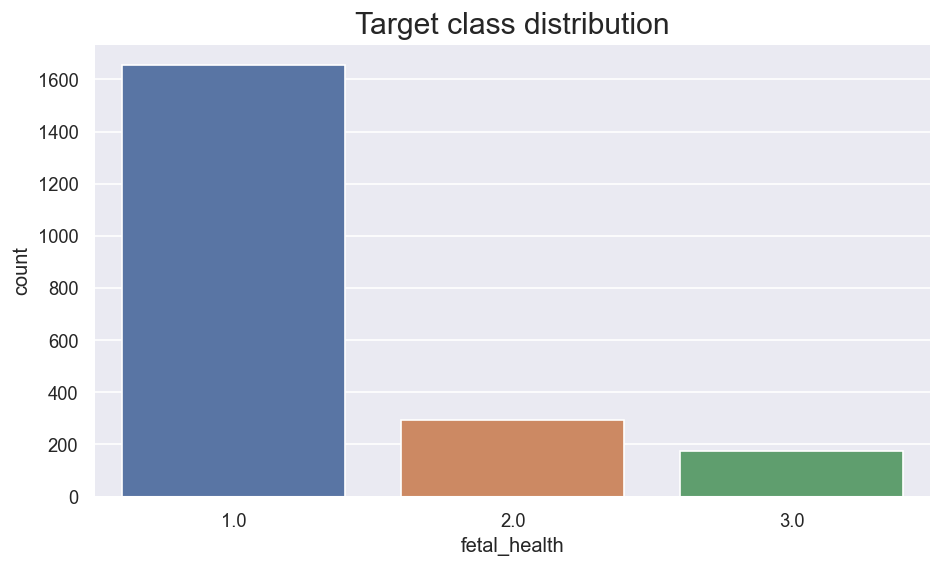

In [87]:
tgt_class = sns.countplot(data=fetal, x='fetal_health')
tgt_class.axes.set_title('Target class distribution', fontsize=18)
plt.show()